#Precipitation Reconstruction – Full-Field Test-Set Evaluation

## Purpose

This notebook allows the reproduction of selected results without executing the full training pipeline available in the repository.

Due to the size and computational cost of the original ERA5 and CPC datasets, the complete model training procedure is not run here. Instead, this notebook performs inference and evaluation using:

- Precomputed test-set data
- Pretrained model weights
- Precomputed ERA5 benchmark fields

The goal is to provide a lightweight and reproducible demonstration of the evaluation workflow.

---

## Experimental configuration considered

This notebook focuses on the best-performing configuration identified in the project.

In particular:

- **Modeling strategy:** Approach 1 – Full-field reconstruction  
- **Predictors:** Principal components (PCs) derived from ERA5 atmospheric variables  
- **Number of variables:** 8 selected predictors (the configuration that yielded the highest skill)  
- **Dimensionality:** 400 principal components retained per variable  
- **Target:** Full CPC daily precipitation field (flattened over land grid points)

The neural network predicts the full precipitation field directly, which is subsequently reshaped to reconstruct spatial maps.

---

## Evaluation scope

The notebook evaluates the trained model on the independent test set and compares its performance against ERA5 precipitation using multiple complementary diagnostics.

The analysis includes:

- Global RMSE and MAE, correlation and other metrics over land grid points
- Scatter plots comparing predicted and observed precipitation  
- Seasonal performance analysis (DJF, MAM, JJA, SON)  
- Quantile-based diagnostics to assess performance across precipitation intensities  
- Maps of correlation differences (ML − ERA5)  
- Regional analysis over selected subdomains  

###**Set up**
First we install the libraries we need and we importa them, and secondly we can connect to the drive

In [ ]:
!pip -q install cartopy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 46.7 MB/s eta 0:00:00


In [ ]:
from google.colab import drive
from pathlib import Path
import os
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.ticker as mticker
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
import pandas as pd

In [ ]:
from pathlib import Path
import urllib.request
import zipfile

ASSET_URL = "https://github.com/alexandrakovacevic217/precip-ml/releases/download/v1.0-demo/demo_assets_v1.zip"

DATA_DIR = Path("data")
ZIP_PATH = DATA_DIR / "demo_assets_v1.zip"
EXTRACT_DIR = DATA_DIR / "demo_assets"

DATA_DIR.mkdir(parents=True, exist_ok=True)

if not ZIP_PATH.exists():
    print("Downloading demo assets...")
    urllib.request.urlretrieve(ASSET_URL, ZIP_PATH)
else:
    print("Zip already present:", ZIP_PATH)

if not EXTRACT_DIR.exists():
    print("Extracting demo assets...")
    with zipfile.ZipFile(ZIP_PATH, "r") as z:
        z.extractall(DATA_DIR)
else:
    print("Demo assets already extracted:", EXTRACT_DIR)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Then we define the paths to our datas

In [ ]:
BASE_DIR = Path("data/demo_assets")

#Define paths to artifacts
X_TEST_PATH   = BASE_DIR / "X_test.npz"
Y_TEST_PATH   = BASE_DIR / "y_test.npz"
IMASK_PATH    = BASE_DIR / "imask.npy"
META_PATH     = BASE_DIR / "meta.npy"
LAT_PATH      = BASE_DIR / "lat.npy"
LON_PATH      = BASE_DIR / "lon.npy"
DATES_PATH    = BASE_DIR / "dates_test.npy"

MODEL_PATH    = BASE_DIR / "best_model.keras"
HIST_PATH     = BASE_DIR / "train_history.npy"
CPC_MAP_PATH  = BASE_DIR / "cpc_test_map.npz"
ERA5_MAP_PATH = BASE_DIR / "era5_test_map.npz"
ERA5_FLAT_PATH= BASE_DIR / "era5_test.npz"


###**Data**

In this notebook I work with precomputed test-set artifacts exported from the full training pipeline.
The goal is to make the analysis *reproducible* and *lightweight*: you can run all evaluation steps without re-downloading the original raw datasets or re-training the model.

The artifacts loaded below are:

- ***X_test*** *(time, N_in PCs)* : input features fed to the neural network for the test period. We decompose the each ERA5 predictors via EOFs and retain just a number N_in of PCs for each predictors and concatenate them.

- **y_test** *(time,latxlon)* : target precipitation field used for evaluation (CPC). Just land data.

- **lat, lon** : latitude/longitude grid vectors used to reshape fields and plot global maps.

- **dates** : array of dates corresponding to the test samples (daily resolution).

- **imask** : land–sea mask on the same grid (useful to restrict metrics/plots to land only).

- **meta** : metadata dictionary describing the dataset and preprocessing choices (e.g., normalization, split details, etc.).

- **era5_test_flat** *(time, latxlon)* : ERA5 precipitation for the test set used as a *benchmark* in a flattened form (used for fast, global point-wise comparisons).

- **era5_test_map** *(time, lat, lon)* : ERA5 precipitation fields maps which is used as a bec(used for spatial plots and map-based metrics).

- **cpc_test_map** *(time, lat, lon)* : CPC precipitation fields reshaped as maps (reference “observed” target used for validation and evaluation).

- **best_model.keras** : trained neural network weights used to generate ML predictions on the test set.

- **train_history** : value (train loss, val loss) of the different epochs during training

❗**NB**❗ Originally, ERA5 precipitation and CPC precipitation were defined on different spatial grids.
To enable direct pixel-wise comparison and metric computation, ERA5 precipitation was interpolated onto the CPC grid during preprocessing.






In [ ]:
# ===== Load arrays =====
X_test = np.load(X_TEST_PATH)["X_test"]
y_test = np.load(Y_TEST_PATH)["y_test"]

imask = np.load(IMASK_PATH)
meta = np.load(META_PATH, allow_pickle=True).item()

lat = np.load(LAT_PATH)
lon = np.load(LON_PATH)
dates = np.load(DATES_PATH)


era5_test_flat = np.load(ERA5_FLAT_PATH)["era5_test"]
cpc_test_map = np.load(CPC_MAP_PATH)["cpc_test_map"]
era5_test_map = np.load(ERA5_MAP_PATH)["era5_test_map"]

# ===== Load model =====
model = tf.keras.models.load_model(MODEL_PATH, compile=False)

print("Loaded successfully ")
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)
print("ERA5 flat:", era5_test_flat.shape)
print("ERA5 map:", era5_test_map.shape)
print("CPC map:", cpc_test_map.shape)

Loaded successfully 
X_test: (1460, 4800)
y_test: (1460, 2846)
ERA5 flat: (1460, 2846)
ERA5 map: (1460, 40, 100)
CPC map: (1460, 40, 100)


###**Helper Functions**





In [ ]:
# @title
def unflatten_to_map(flat_vector, imask, lat_size, lon_size):
    """
    Reconstruct a 2D (lat, lon) map from a 1D vector defined only on valid grid points.

    Parameters
    ----------
    flat_vector : array-like, shape (n_valid,)
        Values defined only on valid grid cells (e.g., land cells or non-missing cells).
    imask : array-like (bool or int indices)
        Mask selecting valid grid cells in the flattened (lat*lon) domain.
        - If boolean: True where the grid cell is valid.
        - If integer array: indices of valid cells.
    lat_size, lon_size : int
        Spatial grid dimensions of the target map.

    Returns
    -------
    map2d : ndarray, shape (lat_size, lon_size)
        Full map with NaNs on invalid cells and values filled on valid cells.
    """
    full = np.full(lat_size * lon_size, np.nan)
    full[imask] = flat_vector
    return full.reshape(lat_size, lon_size)


def add_feat_plt(ax, ylabels_left=False, ylabels_top=False, ylabels_right=False, ylabels_bottom=False):
    """
    Add cartographic features and gridlines to a Cartopy axis.

    This helper standardizes map appearance across the notebook:
    - coastlines
    - land shading
    - geographic extent
    - labeled gridlines (configurable per subplot)

    Notes
    -----
    The extent is currently set to a fixed region:
        [-10, 40, 30, 50]  (lon_min, lon_max, lat_min, lat_max)
    Adjust it if you want global plots or a different focus area.
    """
    extent = [-10, 40, 30, 50]

    ax.coastlines(resolution='auto', color='k')
    ax.set_extent(extent, crs=ccrs.PlateCarree())
    ax.add_feature(cfeature.LAND, facecolor=(0.8, 0.8, 0.8))

    gl = ax.gridlines(color='k', linestyle='--', draw_labels=True)

    # Cartopy API changed over versions; this try/except keeps compatibility
    try:
        gl.top_labels = ylabels_top
        gl.left_labels = ylabels_left
        gl.bottom_labels = ylabels_bottom
        gl.right_labels = ylabels_right
    except Exception:
        gl.xlabels_top = ylabels_top
        gl.ylabels_left = ylabels_left
        gl.xlabels_bottom = ylabels_bottom
        gl.ylabels_right = ylabels_right

    # Visual style for gridlines and labels
    gl.xlines = False
    gl.ylines = False
    gl.xlocator = mticker.FixedLocator(np.arange(-180, 180, 40))
    gl.ylocator = mticker.FixedLocator(np.arange(-60, 60, 30))
    gl.xformatter = LONGITUDE_FORMATTER
    gl.yformatter = LATITUDE_FORMATTER
    gl.xlabel_style = {'size': 13, 'color': 'gray'}
    gl.ylabel_style = {'size': 13, 'color': 'gray'}


def get_test_index_from_date(dates_test, selected_date):
    """
    Return the time index corresponding to a selected date string.

    Parameters
    ----------
    dates_test : array-like of str
        Array of date strings formatted as "YYYY-MM-DD".
    selected_date : str
        Target date string, must exactly match one element in dates_test.

    Returns
    -------
    idx : int
        Index along the time dimension corresponding to the requested date.

    Raises
    ------
    ValueError
        If selected_date is not found in dates_test.
    """
    matches = np.where(dates_test == selected_date)[0]
    if len(matches) == 0:
        raise ValueError(f"Date {selected_date} not found in test set.")
    return int(matches[0])


def correlation_spatial_np(X, Y):
    """
    Spatial correlation computed independently for each time step.

    For each day t, the correlation is computed across the spatial domain (lat, lon)
    after removing the spatial mean of that day (i.e., using anomalies).

    Parameters
    ----------
    X, Y : ndarray, shape (time, lat, lon)
        Two spatio-temporal fields defined on the same grid.

    Returns
    -------
    r_t : ndarray, shape (time,)
        Spatial correlation time series (one correlation value per time step).
    """
    mean_X = np.nanmean(X, axis=(1, 2))
    mean_Y = np.nanmean(Y, axis=(1, 2))

    fluct_X = X - mean_X[:, None, None]
    fluct_Y = Y - mean_Y[:, None, None]

    num = np.nansum(fluct_X * fluct_Y, axis=(1, 2))
    den = np.sqrt(np.nansum(fluct_X**2, axis=(1, 2)) * np.nansum(fluct_Y**2, axis=(1, 2)))

    r_t = num / den
    r_t = np.where(den == 0, np.nan, r_t)
    return r_t


def correlation_temporal_np(X, Y):
    """
    Temporal correlation computed independently for each grid cell.

    For each (lat, lon), the correlation is computed across time after removing
    the temporal mean at that grid cell (i.e., using anomalies).

    Parameters
    ----------
    X, Y : ndarray, shape (time, lat, lon)
        Two spatio-temporal fields defined on the same grid.

    Returns
    -------
    r_map : ndarray, shape (lat, lon)
        Map of temporal correlations (one correlation value per grid cell).
    """
    mean_X = np.nanmean(X, axis=0)
    mean_Y = np.nanmean(Y, axis=0)

    fluct_X = X - mean_X
    fluct_Y = Y - mean_Y

    num = np.nansum(fluct_X * fluct_Y, axis=0)
    den = np.sqrt(np.nansum(fluct_X**2, axis=0) * np.nansum(fluct_Y**2, axis=0))

    r_map = num / den
    r_map = np.where(den == 0, np.nan, r_map)
    return r_map


def compute_metrics(X_ml, X_obs):
    """
    Compute aggregate performance metrics between predicted and observed fields.

    Metrics are computed over all finite points in space and time.

    Parameters
    ----------
    X_ml : ndarray, shape (time, lat, lon)
        Model predictions (e.g., ML-corrected precipitation).
    X_obs : ndarray, shape (time, lat, lon)
        Reference observations (e.g., CPC precipitation).

    Returns
    -------
    metrics : dict
        Dictionary with:
        - MAE, RMSE, Bias
        - R² (global)
        - Mean Spatial Corr (average over time of spatial correlations)
        - Mean Temporal Corr (average over space of temporal correlations)
    """
    mae = np.nanmean(np.abs(X_ml - X_obs))
    rmse = np.sqrt(np.nanmean((X_ml - X_obs) ** 2))
    bias = np.nanmean(X_ml - X_obs)

    # Global R² computed on all finite points
    ss_res = np.nansum((X_obs - X_ml) ** 2)
    ss_tot = np.nansum((X_obs - np.nanmean(X_obs)) ** 2)
    r2 = 1 - (ss_res / ss_tot) if ss_tot != 0 else np.nan

    # Correlation diagnostics
    r_spatial = correlation_spatial_np(X_ml, X_obs)
    mean_r_spatial = np.nanmean(r_spatial)

    r_temporal = correlation_temporal_np(X_ml, X_obs)
    mean_r_temporal = np.nanmean(r_temporal)

    return {
        "MAE": mae,
        "RMSE": rmse,
        "Bias": bias,
        "R²": r2,
        "Mean Spatial Corr": mean_r_spatial,
        "Mean Temporal Corr": mean_r_temporal
    }


def scatter_density_plot(
    PR_true, PR_pred,
    title="Prediction vs Observation",
    xlabel="Observed (CPC)", ylabel="Predicted",
    vmax=None, gridsize=120, bins="log",
    save_path=None, clip_max=None
):
    """
    Scatter-density plot (hexbin) comparing predictions vs observations.

    This plot summarizes point-wise agreement over the entire dataset by
    binning points into a hexagonal grid and coloring by (log) counts.

    Parameters
    ----------
    PR_true, PR_pred : array-like
        Can be either:
        - 2D arrays (time, n_valid) in flattened form
        - 3D arrays (time, lat, lon) in map form
    title : str
        Plot title.
    xlabel, ylabel : str
        Axis labels.
    gridsize : int
        Hexbin resolution (higher = finer grid).
    bins : {"log", None}
        If "log", colors represent log10(count).
    vmax : float or None
        Optional cap for the colormap.
    clip_max : float or None
        Optional clipping of x/y values to reduce the visual impact of outliers.
    save_path : str or None
        If provided, saves the figure to disk.

    Returns
    -------
    None
        Displays the plot.
    """
    # Convert to numpy (also supports xarray DataArray)
    PR_true = PR_true.values if hasattr(PR_true, "values") else PR_true
    PR_pred = PR_pred.values if hasattr(PR_pred, "values") else PR_pred

    # Flatten and remove NaNs/infs
    mask = np.isfinite(PR_true) & np.isfinite(PR_pred)
    x = PR_true[mask].ravel()
    y = PR_pred[mask].ravel()

    # Optional clipping to improve readability if there are rare extreme outliers
    if clip_max is not None:
        x = np.clip(x, 0, clip_max)
        y = np.clip(y, 0, clip_max)

    if x.size == 0:
        raise ValueError("No valid points after NaN filtering.")

    # Robust 1:1 limits
    lim_min = min(np.nanmin(x), np.nanmin(y))
    lim_max = max(np.nanmax(x), np.nanmax(y))

    plt.figure(figsize=(5, 5))
    hb = plt.hexbin(x, y, gridsize=gridsize, cmap="viridis", bins=bins, vmax=vmax)
    plt.plot([lim_min, lim_max], [lim_min, lim_max], "r--", linewidth=1)  # 1:1 reference line

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)

    cb = plt.colorbar(hb, fraction=0.046, pad=0.04)
    cb.set_label("log10(count)" if bins == "log" else "count")

    plt.xlim(lim_min, lim_max)
    plt.ylim(lim_min, lim_max)
    plt.gca().set_aspect("equal", adjustable="box")
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches="tight")
    plt.show()


###**Neural Network**

The model used for training is a fully connected Multi-Layer Perceptron (MLP), whose structure is shown in the figure (scaled rapresantation)

The architecture is organized as follows:

- Input layer: 4800-dimensional feature vector

- Dense (2048 units) + Batch Normalization + Dropout

- Dense (1024 units) + Batch Normalization + Dropout

- Dense (512 units) + Batch Normalization + Dropout

- Output layer (linear activation) with 2846 units

![MLP Architecture](MLP_fields_notebook.png)

**Model Definition and Training Routine**

Below is the TensorFlow implementation used to define and train the network.

```
def build_model(input_shape, output_dim, activation='relu'):
    model = tf.keras.models.Sequential([
        tf.keras.Input(shape=input_shape, dtype='float32'),
        tf.keras.layers.Dense(2048, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1024, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(512, activation=activation),
        tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(output_dim, activation='linear', dtype='float32')
    ])
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
                  loss='mse', metrics=['mae'])
    return model
```


```
def build_and_train(X_train,y_train, X_val, y_val, activation='relu',batch_size=512, callbacks=None):
    # Set some options
    # Set mixed precision policy
    mixed_precision.set_global_policy('mixed_float16')
    # Callback globale
    early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=False)
    # input and output
    input_shape = (X_train.shape[1],)
    output_dim = y_train.shape[1]
    # build model
    model = build_model(input_shape, output_dim, activation=activation)
    # train model (using default epochs and batch_size)
    # Allena e restituisci sia modello che storia del training
    history = train_model(model, X_train, y_train, X_val, y_val, batch_size=batch_size, callbacks=callbacks)
    return model, history
```
**Design Choices**

The network is trained using:

- ReLU activation in hidden layers, enabling non-linear feature interactions.

- Linear activation in the output layer, appropriate for continuous regression.

- Mean Squared Error (MSE) as the loss function.

- Mean Absolute Error (MAE) as an additional evaluation metric.

- Adam optimizer with learning rate 10^3.

**Regularization and Stability**

To improve training stability and generalization:

- Batch Normalization is applied after each dense layer to stabilize internal feature distributions.

- Dropout (0.2) randomly deactivates 20% of neurons during training, reducing overfitting.

- Early Stopping monitors validation loss and prevents unnecessary training once performance saturates.

- Mixed precision (mixed_float16) is enabled during training to improve computational efficiency.



In [ ]:
#summury of the model
print("Model architecture:")
model.summary()

print("\nInput shape:", model.input_shape)
print("Output shape:", model.output_shape)
print("Total parameters:", model.count_params())

Model architecture:


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 2048)           │     9,832,448 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 2048)           │         8,192 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1024)           │     2,098,176 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 2846)           │     1,459,998 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,929,758 (53.14 MB)

 Trainable params: 13,922,590 (53.11 MB)

 Non-trainable params: 7,168 (28.00 KB)


Input shape: (None, 4800)
Output shape: (None, 2846)
Total parameters: 13929758


In [ ]:
#run the model
print("Running inference...")
y_pred = model.predict(X_test)
print("Prediction shape:", y_pred.shape)

Running inference...
46/46 ━━━━━━━━━━━━━━━━━━━━ 5s 94ms/step
Prediction shape: (1460, 2846)


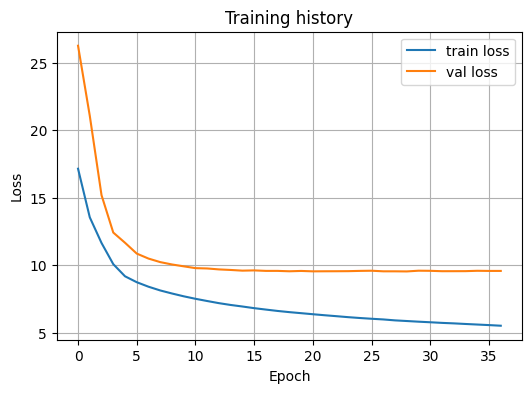

In [ ]:
#train and val loss plot
hist = np.load(HIST_PATH, allow_pickle=True).item()
plt.figure(figsize=(6,4))
plt.plot(hist["loss"], label="train loss")
if "val_loss" in hist:
    plt.plot(hist["val_loss"], label="val loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training history")
plt.grid(True)
plt.legend()
plt.show()

**Description**

Both losses decrease rapidly in the first epochs, indicating effective learning of the underlying mapping. While the training loss continues to decrease steadily, the validation loss stabilizes after approximately 10–15 epochs, suggesting that the model has reached its generalization capacity and further training would provide limited improvement.

### **RESULTS ANALYSIS**

We assess the predictive skill of the trained MLP on the independent test set by systematically comparing its outputs with CPC observations (reference dataset) and ERA5 precipitation (benchmark baseline).

The analysis comprises:

1. Spatial comparison of daily precipitation fields  
2. Summary performance metrics  
3. Predicted–observed scatter-density diagnostics  
4. Seasonal and quantile-resolved correlation analysis (ML vs ERA5)  
5. Spatial distribution of temporal correlation differences (ML − ERA5)  
6. Regional-scale correlation assessment  



In [ ]:
#Definition of some constants and size
lat_size = meta["lat_cpc"]
lon_size = meta["lon_cpc"]
T = y_pred.shape[0]

In [ ]:
#Recostrunction of the map ml_test_map from the flatten verison (y_pred)
ml_test_map = np.empty((T, lat_size, lon_size), dtype=np.float32)
for t in range(T):
    ml_test_map[t] = unflatten_to_map(y_pred[t], imask, lat_size, lon_size)

print("ML maps shape:", ml_test_map.shape)
print("CPC maps shape:", cpc_test_map.shape)
print("ERA5 maps shape:", era5_test_map.shape)

ML maps shape: (1460, 40, 100)
CPC maps shape: (1460, 40, 100)
ERA5 maps shape: (1460, 40, 100)


**1. SINGLE DAY ANALYSIS**

In [ ]:
#selection of one day for the map
selected_date = "2020-10-03"
ti = get_test_index_from_date(dates, selected_date)

cpc_map = cpc_test_map[ti]
ml_map  = ml_test_map[ti]
era5_map = era5_test_map[ti]


/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_land.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.12/dist-packages/cartopy/io/__init__.py:242: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


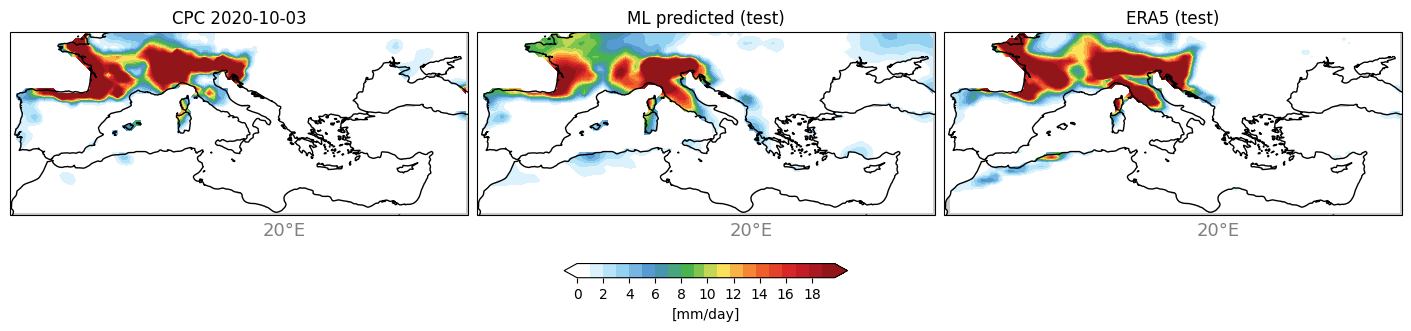

In [ ]:
#1.PLOT of CPC, ML test, ERA5

#colors palette for the plots
colori = [tuple(np.array((255, 255, 255)) / 255),  # white
          tuple(np.array((157, 218, 247)) / 255),  # blue
          tuple(np.array((72, 142, 202)) / 255),  # dark blue
          tuple(np.array((73, 181, 70)) / 255),  # green
          tuple(np.array((250, 232, 92)) / 255),  # yellow
          tuple(np.array((245, 106, 41)) / 255),  # orange
          tuple(np.array((211, 31, 40)) / 255),  # red
          tuple(np.array((146, 21, 25)) / 255)]  # dark red
palette = LinearSegmentedColormap.from_list('WhiteBlueGreenYellowRed', colori, N=20)

#levels of the rapresentation of teh precipitation
levels = np.arange(0, 20, 0.25)

#plot

fig, axs = plt.subplots(
    nrows=1, ncols=3,
    subplot_kw={'projection': ccrs.PlateCarree()},
    figsize=(14, 4),
    constrained_layout=True
)

cs = axs[0].contourf(lon, lat, cpc_map, levels=levels, transform=ccrs.PlateCarree(),
                     cmap=palette, extend='both')
axs[0].set_title(f"CPC {selected_date}")
add_feat_plt(axs[0], ylabels_left=True, ylabels_bottom=True)

axs[1].contourf(lon, lat, ml_map, levels=levels, transform=ccrs.PlateCarree(),
                cmap=palette, extend='both')
axs[1].set_title("ML predicted (test)")
add_feat_plt(axs[1], ylabels_bottom=True)

axs[2].contourf(lon, lat, era5_map, levels=levels, transform=ccrs.PlateCarree(),
                cmap=palette, extend='both')
axs[2].set_title("ERA5 (test)")
add_feat_plt(axs[2], ylabels_right=True, ylabels_bottom=True)

cbar = fig.colorbar(cs, ax=axs, orientation='horizontal', fraction=0.05, pad=0.08)
cbar.set_label("[mm/day]")

plt.show()


**2. AGGREGATE METRICS**

In [ ]:
# AGGREGATE METRICS ML VS CPC / ERA5 VS CPC
metrics_ml = compute_metrics(ml_test_map, cpc_test_map)
metrics_era5 = compute_metrics(era5_test_map, cpc_test_map)

/tmp/ipython-input-554392469.py:149: RuntimeWarning: Mean of empty slice
  mean_X = np.nanmean(X, axis=0)
/tmp/ipython-input-554392469.py:150: RuntimeWarning: Mean of empty slice
  mean_Y = np.nanmean(Y, axis=0)
/tmp/ipython-input-554392469.py:158: RuntimeWarning: invalid value encountered in divide
  r_map = num / den


In [ ]:
#create a table
df = pd.DataFrame({
    "Metric": list(metrics_ml.keys()),
    "ML": list(metrics_ml.values()),
    "ERA5": list(metrics_era5.values())
})

df

,Metric,ML,ERA5
0,MAE,1.336014,1.163685
1,RMSE,3.143010,3.244185
2,Bias,-0.183426,0.264073
3,R²,0.460027,0.425511
4,Mean Spatial Corr,0.610676,0.670181
5,Mean Temporal Corr,0.591576,0.672187


**3. SCATTER PLOT**

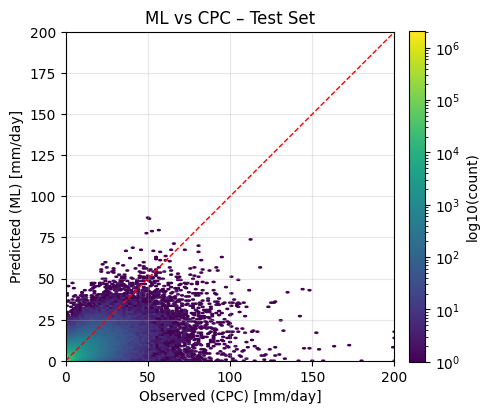

In [ ]:
#scatter plot ML VS CPC
scatter_density_plot(
    PR_true=y_test,
    PR_pred=y_pred,
    title="ML vs CPC – Test Set",
    xlabel="Observed (CPC) [mm/day]",
    ylabel="Predicted (ML) [mm/day]",
    clip_max=200
)

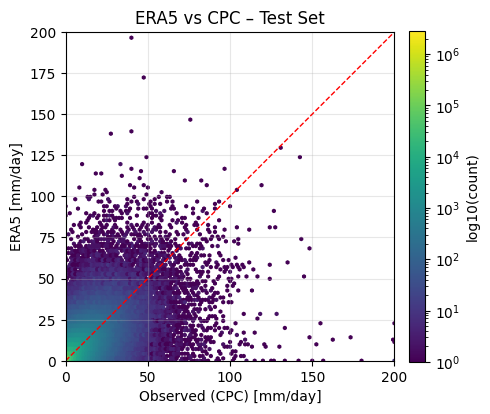

In [ ]:
#scatter plot ERA5 VS CPC
scatter_density_plot(
    PR_true=y_test,
    PR_pred=era5_test_flat,
    title="ERA5 vs CPC – Test Set",
    xlabel="Observed (CPC) [mm/day]",
    ylabel="ERA5 [mm/day]",
    clip_max=200
)

**4. Seasonal Correlation Analysis (ML vs ERA5)**

Distribution of correlation values across seasons

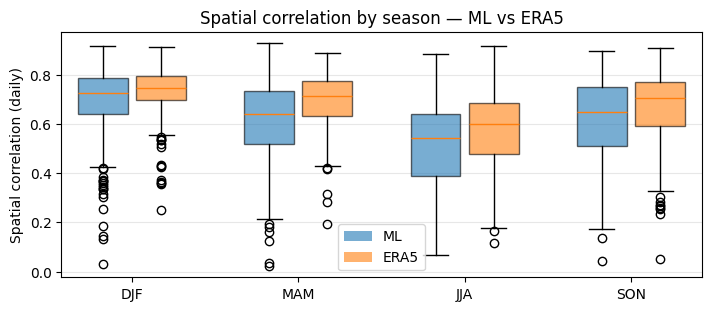

In [ ]:
# 1) Compute daily spatial correlation (across grid points)
#    For each day, compute the spatial correlation between CPC (reference)
#    and ML predictions, and between CPC and ERA5 (benchmark).
corr_ml   = correlation_spatial_np(cpc_test_map, ml_test_map)
corr_era5 = correlation_spatial_np(cpc_test_map, era5_test_map)

# 2) Assign each test sample to a meteorological season based on its date
dt = pd.to_datetime(np.asarray(dates))
season = pd.Series(dt.month).map(lambda m: "DJF" if m in [12,1,2] else
                                           "MAM" if m in [3,4,5]  else
                                           "JJA" if m in [6,7,8]  else "SON").values

# 3) Prepare seasonal subsets of daily spatial correlation values
#    for ML and ERA5, preserving the order DJF–MAM–JJA–SON.
order = ["DJF", "MAM", "JJA", "SON"]
data_ml   = [corr_ml[season == s] for s in order]
data_era5 = [corr_era5[season == s] for s in order]

fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)

# Define x-axis positions for grouped boxplots
pos = np.arange(len(order)) * 2.0

# Create boxplots for ML and ERA5 side by side
bp_ml = ax.boxplot(data_ml, positions=pos, widths=0.6,
                   patch_artist=True)

bp_era5 = ax.boxplot(data_era5, positions=pos+0.7, widths=0.6,
                     patch_artist=True)

# Apply consistent color scheme:
# blue for ML predictions, orange for ERA5 benchmark
for box in bp_ml["boxes"]:
    box.set(facecolor="#1f77b4", alpha=0.6)   # ML

for box in bp_era5["boxes"]:
    box.set(facecolor="#ff7f0e", alpha=0.6)   # ERA5

# Configure axis labels and formatting
ax.set_xticks(pos+0.35)
ax.set_xticklabels(order)
ax.set_ylabel("Spatial correlation (daily)")
ax.set_title("Spatial correlation by season — ML vs ERA5")
ax.grid(True, axis="y", alpha=0.3)

# Add legend consistent with color mapping
from matplotlib.patches import Patch
ax.legend(handles=[
    Patch(facecolor="#1f77b4", alpha=0.6, label="ML"),
    Patch(facecolor="#ff7f0e", alpha=0.6, label="ERA5")
])

plt.show()


**Description**

This plot shows the distribution of daily spatial correlation between CPC and the predicted precipitation fields, computed over the full domain and grouped by season (DJF, MAM, JJA, SON). Boxplots summarize the daily values (median, interquartile range, and outliers) for the ML model (blue) and ERA5 (orange).

Across all seasons, ERA5 tends to exhibit slightly higher median correlation than the ML predictions. The gap is most evident in the transition and summer seasons (MAM and JJA), while it appears smaller in winter and autumn (DJF and SON). Both methods show the same seasonal structure, with higher correlations in DJF/SON and reduced skill and larger variability in JJA, reflecting stronger day-to-day changes in spatial patterns during summer.

**4. Quantile-Based Analysis of Precipitation Skill (ML vs ERA5)**


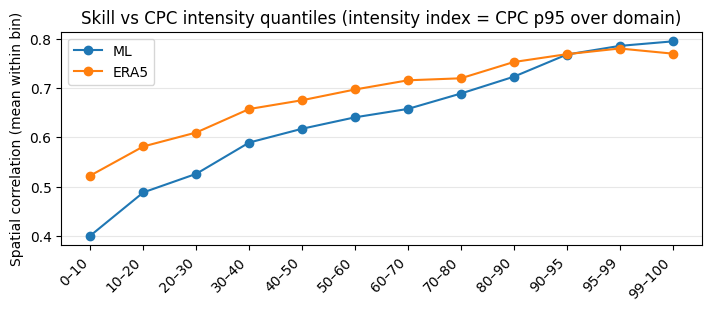

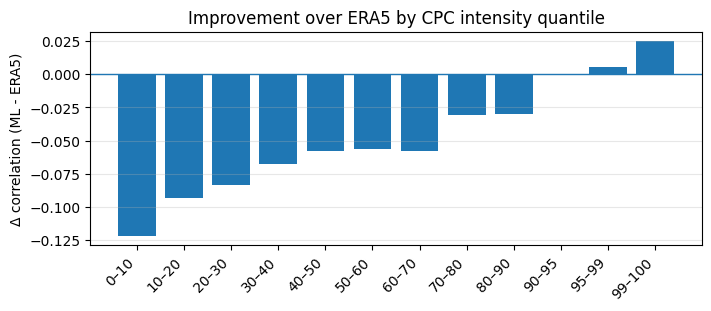

([('0–10', 146),
  ('10–20', 146),
  ('20–30', 146),
  ('30–40', 146),
  ('40–50', 146)],
 ' ... ',
 [('90–95', 73), ('95–99', 58), ('99–100', 15)])

In [ ]:
# Define a daily precipitation-intensity index from CPC:
# for each day, take the 95th percentile over the spatial domain (lat, lon).
# This provides a single scalar per day representing how "intense" precipitation is.
intensity = np.nanpercentile(cpc_test_map, 95, axis=(1,2))

# Define quantile bins of the daily intensity index.
# q_edges are the desired percentiles; edges are the corresponding threshold values.
q_edges = [0,10,20,30,40,50,60,70,80,90,95,99,100]
edges = np.percentile(intensity[np.isfinite(intensity)], q_edges)

# Assign each day to a quantile bin based on its CPC intensity index.
# bin_id ranges from 0 to len(q_edges)-2 (one bin per interval in q_edges).
bin_id = np.digitize(intensity, edges[1:-1], right=True)  # 0..len(q_edges)-2

# Compute mean spatial correlation within each intensity bin for:
# - ML predictions vs CPC
# - ERA5 vs CPC
# Also store the number of days contributing to each bin.
ml_mean, e5_mean, n_days = [], [], []
for b in range(len(q_edges)-1):
    m = (bin_id == b) & np.isfinite(corr_ml) & np.isfinite(corr_era5)
    n_days.append(int(m.sum()))
    ml_mean.append(np.nanmean(corr_ml[m]) if m.sum() > 0 else np.nan)
    e5_mean.append(np.nanmean(corr_era5[m]) if m.sum() > 0 else np.nan)

# Convert to arrays and compute improvement over ERA5 (delta = ML - ERA5)
ml_mean = np.array(ml_mean); e5_mean = np.array(e5_mean)
delta = ml_mean - e5_mean

# Prepare x-axis labels showing the quantile range of each bin
labels = [f"{q_edges[i]}–{q_edges[i+1]}" for i in range(len(q_edges)-1)]
x = np.arange(len(labels))

# Plot 1: Mean spatial correlation as a function of CPC intensity quantile
fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)
ax.plot(x, ml_mean, marker="o", label="ML")
ax.plot(x, e5_mean, marker="o", label="ERA5")
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Spatial correlation (mean within bin)")
ax.set_title("Skill vs CPC intensity quantiles (intensity index = CPC p95 over domain)")
ax.grid(True, axis="y", alpha=0.3)
ax.legend()
plt.show()

# Plot 2: Improvement over ERA5 by intensity quantile (ML - ERA5)
fig, ax = plt.subplots(figsize=(7,3), constrained_layout=True)
ax.bar(x, delta)
ax.axhline(0, linewidth=1)
ax.set_xticks(x); ax.set_xticklabels(labels, rotation=45, ha="right")
ax.set_ylabel("Δ correlation (ML - ERA5)")
ax.set_title("Improvement over ERA5 by CPC intensity quantile")
ax.grid(True, axis="y", alpha=0.3)
plt.show()

# Sanity check: number of test days per quantile bin (to verify sampling robustness)
list(zip(labels, n_days))[:5], " ... ", list(zip(labels, n_days))[-3:]


**Quantile-Resolved Skill Analysis**

The first panel shows the mean spatial correlation (within each bin) as a function of CPC precipitation intensity quantiles.  
The intensity index is defined as the 95th percentile of CPC precipitation over the spatial domain for each day, providing a scalar measure of daily precipitation strength.

A clear monotonic trend emerges: spatial correlation increases with precipitation intensity for both ML and ERA5.  
Low-intensity days (0–30th percentile) exhibit substantially lower correlation values, reflecting the difficulty of accurately reproducing weak or spatially fragmented precipitation patterns.

ERA5 consistently outperforms ML at low-to-moderate intensity levels.  
However, as intensity increases, the performance gap narrows, and for the highest quantiles (≥95th percentile), ML slightly matches or exceeds ERA5.

This suggests that the neural network is particularly effective at capturing the dominant spatial structure associated with strong precipitation events.

**Improvement over ERA5 by Intensity Regime**

The second panel shows the difference in spatial correlation (ML − ERA5) for each precipitation intensity bin.

For low and moderate intensity days, the improvement is negative, indicating that ERA5 provides higher spatial correlation with CPC observations.  
The largest deficit occurs in the lowest quantile range (0–10), where weak precipitation events are especially challenging for the ML model.

The gap progressively decreases as precipitation intensity increases.  
For the highest quantiles (95–99 and 99–100), the improvement becomes positive, indicating that the ML reconstruction slightly outperforms ERA5 during the most intense precipitation events.

This behavior suggests that the neural network captures large-scale structures driving strong events more effectively than ERA5 precipitation fields, while struggling more in weak or diffuse regimes.


**5. Spatial distribution of temporal correlation differences (ML − ERA5)**

/tmp/ipython-input-2394287773.py:149: RuntimeWarning: Mean of empty slice
  mean_X = np.nanmean(X, axis=0)
/tmp/ipython-input-2394287773.py:150: RuntimeWarning: Mean of empty slice
  mean_Y = np.nanmean(Y, axis=0)
/tmp/ipython-input-2394287773.py:158: RuntimeWarning: invalid value encountered in divide
  r_map = num / den


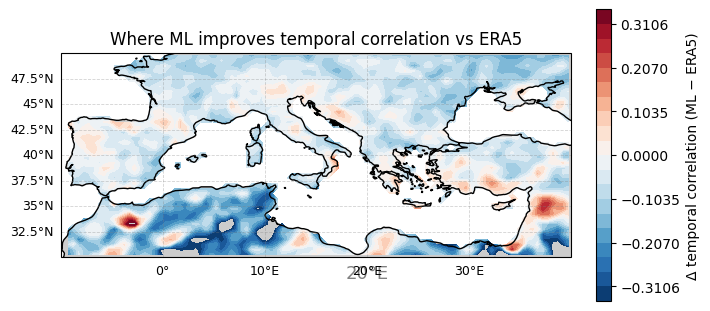

In [ ]:
# Compute temporal correlation at each grid point:
# correlation across time between CPC (reference) and ML predictions,
# and between CPC and ERA5 (benchmark).
corr_map_ml   = correlation_temporal_np(cpc_test_map, ml_test_map)
corr_map_era5 = correlation_temporal_np(cpc_test_map, era5_test_map)

# Difference map: positive values indicate locations where ML improves
# temporal correlation relative to ERA5.
delta_corr = corr_map_ml - corr_map_era5  # > 0 => ML better

# Define robust symmetric color limits using the 98th percentile
# of |Δcorr| to reduce the influence of outliers.
v = np.nanpercentile(np.abs(delta_corr), 98)
levels = np.linspace(-v, v, 21)

fig, ax = plt.subplots(
    figsize=(7, 3),
    subplot_kw={"projection": ccrs.PlateCarree()},
    constrained_layout=True
)

# Add geographic features (coastlines, borders, and axis labels)
add_feat_plt(ax, ylabels_left=True, ylabels_bottom=True)

# Plot Δ temporal correlation (ML - ERA5) using a diverging colormap
cs = ax.contourf(
    lon, lat, delta_corr,
    levels=levels,
    cmap="RdBu_r",
    transform=ccrs.PlateCarree()
)
plt.colorbar(cs, ax=ax, label="Δ temporal correlation (ML − ERA5)")
ax.set_title("Where ML improves temporal correlation vs ERA5")

# Add latitude/longitude gridlines with labels
gl = ax.gridlines(
    crs=ccrs.PlateCarree(),
    draw_labels=True,
    linewidth=0.6,
    color="gray",
    alpha=0.35,
    linestyle="--"
)
gl.top_labels = False
gl.right_labels = False
gl.xlabel_style = {"size": 9}
gl.ylabel_style = {"size": 9}

plt.show()


**Temporal correlation difference (ML − ERA5)**

This map shows the spatial distribution of the difference in temporal correlation between the ML model and ERA5 with respect to CPC observations:

   Δr=r(ML) − r(ERA5)

- Red (positive values) → ML captures temporal variability better than ERA5.

- Blue (negative values) → ERA5 performs better.

- Near zero → comparable performance.

Key features:

- Large areas of the central and northern Mediterranean show small differences, indicating similar skill.

- Extended regions over the southern Mediterranean exhibit negative values, suggesting ERA5 better reproduces the temporal evolution there.

- Localized positive hotspots appear in parts of the western and eastern Mediterranean, where the ML model provides noticeable improvement.

**6. Interactive Regional Skill Analysis**

This interactive section allows you to explore where and when the ML model improves over ERA5.

The map (top panel) shows the grid-point temporal correlation difference  
Δr = r(ML, CPC) − r(ERA5, CPC).  
Red areas indicate better ML performance; blue areas indicate better ERA5 performance.

Using the sliders, you can select a latitude–longitude box.  
The lower panel then displays the daily spatial-correlation difference within the selected region, including a rolling mean and variability band.

This tool helps link spatial patterns of improvement to their temporal evolution over specific subdomains.


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output

dt = pd.to_datetime(np.asarray(dates))

# Precompute: Δ temporal correlation map (ML - ERA5)
corr_map_ml   = correlation_temporal_np(cpc_test_map, ml_test_map)
corr_map_era5 = correlation_temporal_np(cpc_test_map, era5_test_map)
delta_corr_map = corr_map_ml - corr_map_era5

/tmp/ipython-input-2394287773.py:149: RuntimeWarning: Mean of empty slice
  mean_X = np.nanmean(X, axis=0)
/tmp/ipython-input-2394287773.py:150: RuntimeWarning: Mean of empty slice
  mean_Y = np.nanmean(Y, axis=0)
/tmp/ipython-input-2394287773.py:158: RuntimeWarning: invalid value encountered in divide
  r_map = num / den


In [ ]:
lat_min_w = widgets.FloatSlider(
    value=float(np.nanmin(lat)), min=float(np.nanmin(lat)), max=float(np.nanmax(lat)),
    step=0.25, description="lat_min", continuous_update=False
)
lat_max_w = widgets.FloatSlider(
    value=float(np.nanmax(lat)), min=float(np.nanmin(lat)), max=float(np.nanmax(lat)),
    step=0.25, description="lat_max", continuous_update=False
)

lon_min_w = widgets.FloatSlider(
    value=float(np.nanmin(lon)), min=float(np.nanmin(lon)), max=float(np.nanmax(lon)),
    step=0.25, description="lon_min", continuous_update=False
)
lon_max_w = widgets.FloatSlider(
    value=float(np.nanmax(lon)), min=float(np.nanmin(lon)), max=float(np.nanmax(lon)),
    step=0.25, description="lon_max", continuous_update=False
)

rolling_w = widgets.IntSlider(value=30, min=7, max=90, step=1, description="roll(d)")
clip_w = widgets.FloatSlider(value=98, min=90, max=100, step=0.5, description="map clip %", continuous_update=False)

ui = widgets.VBox([
    widgets.HBox([lat_min_w, lat_max_w]),
    widgets.HBox([lon_min_w, lon_max_w]),
    widgets.HBox([rolling_w, clip_w]),
])
display(ui)

In [ ]:
out = widgets.Output()

def update(_=None):
    with out:
        clear_output(wait=True)

        # Ensure bounds are ordered
        lat_min = min(lat_min_w.value, lat_max_w.value)
        lat_max = max(lat_min_w.value, lat_max_w.value)
        lon_min = min(lon_min_w.value, lon_max_w.value)
        lon_max = max(lon_min_w.value, lon_max_w.value)

        # Build regional mask
        mlat = (lat >= lat_min) & (lat <= lat_max)
        mlon = (lon >= lon_min) & (lon <= lon_max)

        if mlat.sum() < 2 or mlon.sum() < 2:
            print("Box too small: select at least 2 points in lat and lon.")
            return

        # Extract subdomain
        cpc_reg  = cpc_test_map[:, mlat][:, :, mlon]
        ml_reg   = ml_test_map[:,  mlat][:, :, mlon]
        era5_reg = era5_test_map[:,mlat][:, :, mlon]

        # Time series: daily spatial-correlation difference over the box
        T = cpc_reg.shape[0]
        corr_ml_day = np.full(T, np.nan)
        corr_era5_day = np.full(T, np.nan)

        for t in range(T):
            a = cpc_reg[t].ravel()
            b1 = ml_reg[t].ravel()
            b2 = era5_reg[t].ravel()

            m1 = np.isfinite(a) & np.isfinite(b1)
            m2 = np.isfinite(a) & np.isfinite(b2)

            if m1.sum() > 10:
                corr_ml_day[t] = np.corrcoef(a[m1], b1[m1])[0,1]
            if m2.sum() > 10:
                corr_era5_day[t] = np.corrcoef(a[m2], b2[m2])[0,1]

        diff = corr_ml_day - corr_era5_day

        roll_n = int(rolling_w.value)
        s = pd.Series(diff)

        # Rolling mean and rolling std
        roll = s.rolling(roll_n, center=True, min_periods=max(5, roll_n//3)).mean()
        std  = s.rolling(roll_n, center=True, min_periods=max(5, roll_n//3)).std()

        # Global mean of the difference
        mu = float(np.nanmean(diff))

        # Figure layout: map on top, time series below
        fig = plt.figure(figsize=(10,6), constrained_layout=True)
        gs = fig.add_gridspec(2, 1, height_ratios=[1.05, 0.95])

        # (1) Map: precomputed Δ temporal corr + selected box
        ax0 = fig.add_subplot(gs[0,0], projection=ccrs.PlateCarree())
        add_feat_plt(ax0, ylabels_left=True, ylabels_bottom=True)

        # Robust symmetric clipping for the color scale
        v = np.nanpercentile(np.abs(delta_corr_map), clip_w.value)
        levels = np.linspace(-v, v, 21)

        cs = ax0.contourf(
            lon, lat, delta_corr_map,
            levels=levels, cmap="RdBu_r",
            transform=ccrs.PlateCarree()
        )
        cb = fig.colorbar(cs, ax=ax0, shrink=0.9, pad=0.02)
        cb.set_label("Δ temporal corr (ML − ERA5)")

        # Draw the selected box
        ax0.plot([lon_min, lon_max, lon_max, lon_min, lon_min],
                 [lat_min, lat_min, lat_max, lat_max, lat_min],
                 transform=ccrs.PlateCarree(), linewidth=2)

        ax0.set_title("Δ temporal correlation (ML − ERA5) with selected box")

        # (2) Time series
        ax1 = fig.add_subplot(gs[1,0])

        # Raw daily difference
        ax1.plot(dt, diff, linewidth=0.7, alpha=0.35, label="Raw difference")

        # ±1σ band
        ax1.fill_between(dt, (roll-std).values, (roll+std).values, alpha=0.18, label="±1σ")

        # Rolling mean
        ax1.plot(dt, roll, linewidth=1.5, label=f"{roll_n}-day rolling mean")

        # Zero baseline and global mean
        ax1.axhline(0, linestyle="--", linewidth=1.0, alpha=0.8, label="Zero baseline")
        ax1.axhline(mu, linestyle=":", linewidth=1.2, alpha=0.9, label=f"Global mean = {mu:.3f}")

        ax1.set_ylabel("corr(CPC, ML) − corr(CPC, ERA5)")
        ax1.set_xlabel("Time")
        ax1.set_title("Box-mean daily spatial correlation difference")
        ax1.grid(True, alpha=0.2)
        ax1.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)

        plt.show()

# Link widgets to the update function
for w in [lat_min_w, lat_max_w, lon_min_w, lon_max_w, rolling_w, clip_w]:
    w.observe(update, names="value")

display(out)
update()



Output()